# 📊 Recreating Figures from VERSE Finite Element Study

This notebook reproduces all figures used in the manuscript based on the **VERSE dataset**, specifically focusing on the **finite element analysis of vertebral strength**.

We combine:
- **Original metadata** from the VERSE study [(Löffler et al., 2020)](https://doi.org/10.1148/ryai.2020190138), which includes volumetric bone mineral density (vBMD) and subject-level information.
- **Finite element results** generated as part of this study, which provide vertebral strength estimates and related metrics across vertebral levels.

---

## 📁 Data Sources

- `ryai190138_AppendixE1.csv`: Supplementary metadata from the original VERSE publication.  
- `verse19fem_AppendixA.csv`: Strength and geometry metrics from our finite element models.

Please ensure appropriate citation of the original VERSE dataset:

> Löffler MT, Sekuboyina A, Jacob A, et al. A Vertebral Segmentation Dataset with Fracture Grading. *Radiol Artif Intell.* 2020;2(4):e190138. [https://doi.org/10.1148/ryai.2020190138](https://doi.org/10.1148/ryai.2020190138)

---

## ⚙️ Notebook Overview

This notebook will:

1. Load and merge dataset files.
2. Visualize key variables (e.g., vBMD, vertebral strength).
3. Perform statistical comparisons and correlation analyses.
4. Recreate all figures used in the manuscript submission.

Use this notebook as a reference for:
- Reproducibility of results
- Generating updated figures
- Exploring additional hypotheses using the same dataset

---

In [9]:
# === Packages ===
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import ttest_ind, chi2_contingency
import seaborn as sns
from scipy.stats import pearsonr
from matplotlib.ticker import MultipleLocator
import os
from pathlib import Path
from IPython.display import HTML, display
from scipy.stats import linregress


# === ADD YOUR DATA PATHS HERE ===
# Please find and reference the original work for this data: https://doi.org/10.1148/ryai.2020190138
path_to_original_verse_summary_data = '../data/meta_data/ryai190138_AppendixE1.csv'

# Additional Data from this publication
path_to_fem_verse_summary_data = '../results/verse19fem_AppendixA.csv'

# Set working directory to notebook's directory
notebook_path = os.path.abspath("")
os.chdir(notebook_path)
print(f"Working directory set to:\n{notebook_path}")

# === Loading Data ===
df_data = pd.read_csv(path_to_original_verse_summary_data)
df_data.rename(columns={
    'BMD':'vBMD (Löffler 2020) [mg/cc]'
}, inplace=True)

df_fem = pd.read_csv(path_to_fem_verse_summary_data)

# Merging dataframes and removing empty columns
df = df_data.merge(df_fem, on=['verse_ID','subject_ID'],how='left')
df.dropna(how='all', inplace=True)
df = df.loc[:, ~df.columns.str.startswith('Unnamed')]

print('Loaded data...')
display(df)


Working directory set to:
/work/boyd_lab/fem/NONLINFEA_VERSE/spineFE-benchmark/notebooks
Loaded data...


,verse_ID,subject_ID,dataset,age_ct,CT_device,Res,vBMD (Löffler 2020) [mg/cc],DXA T-value,CT_image_series,N_vertebrae,...,R.Force 0.2% T9 [kN],R.Force 0.2% T10 [kN],R.Force 0.2% T11 [kN],R.Force 0.2% T12 [kN],R.Force 0.2% L1 [kN],R.Force 0.2% L2 [kN],R.Force 0.2% L3 [kN],R.Force 0.2% L4 [kN],R.Force 0.2% L5 [kN],R.Force 0.2% L6 [kN]
0,12.0,12.0,test secret,77.4,3.0,3.0,61.3,0.2,1 of 1,6.0,...,NaN,4.534,4.236,3.852,NaN,4.028,NaN,NaN,NaN,NaN
1,20.0,20.0,test secret,85.8,1.0,2.0,0.0,-2.1,1 of 1,17.0,...,NaN,4.096,NaN,3.648,NaN,NaN,NaN,3.126,4.492000,NaN
2,29.0,29.0,test secret,50.6,2.0,3.0,106.6,-1.8,1 of 1,17.0,...,3.512,3.532,3.454,3.052,3.174,3.486,3.404,3.420,5.334000,NaN
3,32.0,32.0,test secret,83.3,4.0,2.0,89.6,1.0,1 of 1,6.0,...,NaN,NaN,NaN,4.478,4.550,4.380,4.166,4.384,0.000012,NaN
4,38.0,38.0,test secret,54.1,2.0,3.0,70.4,-3.7,1 of 1,7.0,...,NaN,NaN,3.506,3.136,3.190,3.280,3.292,NaN,5.250000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,256.0,404.0,validation public,59.1,4.0,2.0,138.2,NaN,2 of 2,18.0,...,4.688,4.348,4.250,4.528,4.452,5.006,5.646,5.588,5.728000,NaN
156,264.0,264.0,validation public,29.3,3.0,1.0,142.8,NaN,1 of 1,17.0,...,4.192,4.280,4.866,5.148,NaN,4.598,4.688,4.750,4.782000,NaN
157,269.0,269.0,validation public,41.3,2.0,1.0,96.1,NaN,1 of 1,16.0,...,NaN,NaN,5.054,4.888,5.042,5.390,NaN,NaN,5.982000,NaN
158,276.0,276.0,validation public,74.3,5.0,2.0,109.2,NaN,1 of 1,18.0,...,3.098,3.296,3.598,NaN,3.510,3.738,4.020,3.852,3.616000,NaN


In [3]:
# === Summary Statistics ===
def format_mean_sd(series):
    return f"{series.mean():.1f} ± {series.std():.1f}"

def format_count_percent(series, condition):
    count = condition.sum()
    percent = 100 * count / len(series)
    return f"{count} ({percent:.1f}%)"

def compute_table1(df,filename=None):
    df = df.dropna(subset=['Sex', 'subject_ID']).copy()
    df['subject_ID'] = df['subject_ID'].astype(int)
    df_subj = df.groupby('subject_ID').first().reset_index()

    dxa_means = df.groupby('subject_ID')['DXA T-value'].mean().reset_index()
    df_subj = df_subj.merge(dxa_means, on='subject_ID', suffixes=('', '_mean'))

    male = df_subj[df_subj['Sex'] == 'M'].copy()
    female = df_subj[df_subj['Sex'] == 'F'].copy()

    rows = []

    def add_section(title):
        rows.append({'Section': title, 'Variable': '', 'Overall': '', 'Male': '', 'Female': '', 'p-value': ''})

    # === Demographics ===
    add_section('Demographics')
    rows.append({
        'Section': '', 'Variable': 'Number of Subjects',
        'Overall': len(df_subj), 'Male': len(male), 'Female': len(female), 'p-value': ''
    })
    rows.append({
        'Section': '', 'Variable': 'Age (years)',
        'Overall': format_mean_sd(df_subj['age_ct']),
        'Male': format_mean_sd(male['age_ct']),
        'Female': format_mean_sd(female['age_ct']),
        'p-value': f"{ttest_ind(male['age_ct'], female['age_ct'], nan_policy='omit').pvalue:.3f}",
    })

    # === Bone Densitometry ===
    add_section('Bone Densitometry')
    rows.append({
        'Section': '', 'Variable': 'DXA T-score',
        'Overall': format_mean_sd(df_subj['DXA T-value']),
        'Male': format_mean_sd(male['DXA T-value']),
        'Female': format_mean_sd(female['DXA T-value']),
        'p-value': f"{ttest_ind(male['DXA T-value'], female['DXA T-value'], nan_policy='omit').pvalue:.3f}",
    })
    rows.append({
        'Section': '', 'Variable': 'vBMD (Löffler 2020) [mg/cc]',
        'Overall': format_mean_sd(df_subj['vBMD (Löffler 2020) [mg/cc]']),
        'Male': format_mean_sd(male['vBMD (Löffler 2020) [mg/cc]']),
        'Female': format_mean_sd(female['vBMD (Löffler 2020) [mg/cc]']),
        'p-value': f"{ttest_ind(male['vBMD (Löffler 2020) [mg/cc]'], female['vBMD (Löffler 2020) [mg/cc]'], nan_policy='omit').pvalue:.3f}",
    })
    dxa_avail = ~df_subj['DXA T-value_mean'].isna()
    p_dxa = chi2_contingency(pd.crosstab(df_subj['Sex'], dxa_avail))[1]
    rows.append({
        'Section': '', 'Variable': 'Received DXA',
        'Overall': format_count_percent(df_subj['Sex'], dxa_avail),
        'Male': format_count_percent(male['Sex'], ~male['DXA T-value_mean'].isna()),
        'Female': format_count_percent(female['Sex'], ~female['DXA T-value_mean'].isna()),
        'p-value': f"{p_dxa:.3f}"
    })

    # === Mechanical Variables ===
    add_section('Mechanical Variables')
    for label, col in [
        ('F.Load (nonlinear) [kN]', 'F.Load (nonlinear) [kN]'),
        ('R.Force (0.2%, linear) [kN]', 'R.Force (0.2%, linear) [kN]'),
        ('Number of Vertebrae Assessed', 'N_vertebrae')
    ]:
        m, f, overall = male[col].dropna(), female[col].dropna(), df_subj[col].dropna()
        p_val = ttest_ind(m, f, nan_policy='omit').pvalue if len(m) > 1 and len(f) > 1 else np.nan
        rows.append({
            'Section': '', 'Variable': label,
            'Overall': format_mean_sd(overall),
            'Male': format_mean_sd(m),
            'Female': format_mean_sd(f),
            'p-value': f"{p_val:.3f}" if not np.isnan(p_val) else '',
        })

    p_fx = chi2_contingency(pd.crosstab(df_subj['Sex'], df_subj['N_Fx'] > 0))[1]
    rows.append({
        'Section': '', 'Variable': 'Any Vertebral Fracture',
        'Overall': format_count_percent(df_subj['Sex'], df_subj['N_Fx'] > 0),
        'Male': format_count_percent(male['Sex'], male['N_Fx'] > 0),
        'Female': format_count_percent(female['Sex'], female['N_Fx'] > 0),
        'p-value': f"{p_fx:.3f}",
    })

    if 'Foreign Material' in df_subj.columns:
        p_implant = chi2_contingency(pd.crosstab(df_subj['Sex'], df_subj['Foreign Material'] == True))[1]
        rows.append({
            'Section': '', 'Variable': 'Foreign Material Present',
            'Overall': format_count_percent(df_subj['Sex'], df_subj['Foreign Material'] == True),
            'Male': format_count_percent(male['Sex'], male['Foreign Material'] == True),
            'Female': format_count_percent(female['Sex'], female['Foreign Material'] == True),
            'p-value': f"{p_implant:.3f}",

        })

    # === Contrast Enhancement ===
    contrast_p = chi2_contingency(pd.crosstab(df_subj['Sex'], df_subj['Contrast Enhancement']))[1]
    rows.append({'Section': 'Contrast Enhancement', 'Variable': '', 'Overall': '', 'Male': '', 'Female': '', 'p-value': f"{contrast_p:.3f}"})
    contrast_subj = df.groupby('subject_ID')['Contrast Enhancement'].first().reset_index()
    df_subj = df_subj.merge(contrast_subj, on='subject_ID', suffixes=('', '_contrast'))
    male = df_subj[df_subj['Sex'] == 'M'].copy()
    female = df_subj[df_subj['Sex'] == 'F'].copy()
    contrast_p = chi2_contingency(pd.crosstab(df_subj['Sex'], df_subj['Contrast Enhancement']))[1]
    for i, ctype in enumerate(df_subj['Contrast Enhancement'].dropna().unique()):
        rows.append({
            'Section': '', 'Variable': f'Contrast: {ctype}',
            'Overall': format_count_percent(df_subj['Sex'], df_subj['Contrast Enhancement'] == ctype),
            'Male': format_count_percent(male['Sex'], male['Contrast Enhancement'] == ctype),
            'Female': format_count_percent(female['Sex'], female['Contrast Enhancement'] == ctype),
            'p-value': ''
        })

    # === CT Device ===
    ct_device_map = {
        1: 'Philips Brilliance 64',
        2: 'Philips iCT',
        3: 'Philips IQon',
        4: 'Siemens Somatom Definition AS+',
        5: 'Siemens Somatom Definition AS'
    }
    df_subj['CT_device_label'] = df_subj['CT_device'].map(ct_device_map)
    male['CT_device_label'] = male['CT_device'].map(ct_device_map)
    female['CT_device_label'] = female['CT_device'].map(ct_device_map)

    ct_p = chi2_contingency(pd.crosstab(df_subj['Sex'], df_subj['CT_device_label']))[1]
    rows.append({'Section': 'CT Device', 'Variable': '', 'Overall': '', 'Male': '', 'Female': '', 'p-value': f"{ct_p:.3f}"})

    ct_p = chi2_contingency(pd.crosstab(df_subj['Sex'], df_subj['CT_device_label']))[1]
    for i, device in enumerate(sorted(df_subj['CT_device_label'].dropna().unique())):
        rows.append({
            'Section': '', 'Variable': f'CT Device: {device}',
            'Overall': format_count_percent(df_subj['Sex'], df_subj['CT_device_label'] == device),
            'Male': format_count_percent(male['Sex'], male['CT_device_label'] == device),
            'Female': format_count_percent(female['Sex'], female['CT_device_label'] == device),
            'p-value': ''
        })
    
    df = pd.DataFrame(rows)

    if filename:
        df.to_csv(filename)

    return df

filename = '../results/tables/verse19fem_table_1.csv'
table1 = compute_table1(df,filename)
print("Table 1: Summary Statistics",filename)
display(table1)

Table 1: Summary Statistics ../results/tables/verse19fem_table_1.csv


,Section,Variable,Overall,Male,Female,p-value
0,Demographics,,,,,
1,,Number of Subjects,141,49,92,
2,,Age (years),66.1 ± 15.0,59.8 ± 16.6,69.4 ± 12.9,0.000
3,Bone Densitometry,,,,,
4,,DXA T-score,-1.5 ± 1.8,-1.5 ± 1.8,-1.5 ± 1.8,0.962
5,,vBMD (Löffler 2020) [mg/cc],77.8 ± 53.6,104.9 ± 59.5,63.4 ± 44.1,0.000
6,,Received DXA,107 (75.9%),31 (63.3%),76 (82.6%),0.019
7,Mechanical Variables,,,,,
8,,F.Load (nonlinear) [kN],3.4 ± 1.6,4.0 ± 1.9,3.1 ± 1.4,0.004
9,,"R.Force (0.2%, linear) [kN]",3.6 ± 1.1,3.8 ± 1.2,3.4 ± 1.0,0.021


In [4]:
# === Figure 1 ===
display(HTML('<img src="../results/figures/verse19fem_figure_1_AB.svg" width="1000">'))
print('Figure 1. Overview of the VeSe 2019 dataset and its extension in this study.')

Figure 1. Overview of the VeSe 2019 dataset and its extension in this study.


In [5]:
# === Figure 2 ===
display(HTML('<img src="../results/figures/verse19fem_figure_2_AB.svg" width="1000">'))

print('Figure 2. Phantomless versus synchronous phantom calibration.')

Figure 2. Phantomless versus synchronous phantom calibration.


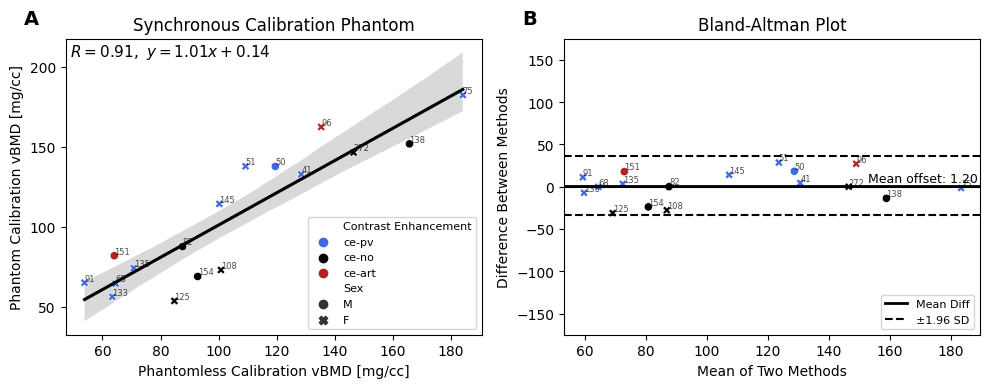

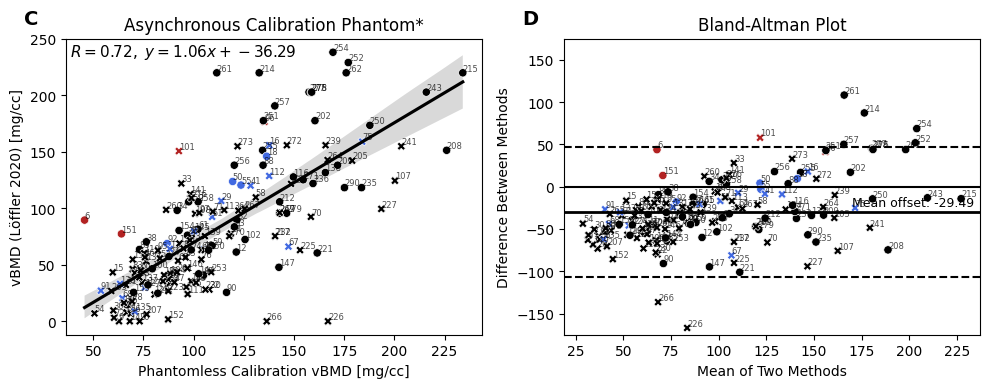

Figure 3. Comparison of BMD measurements across calibration methods.


In [17]:
# === Figure 3 ===
def corr_BA_plot(
    df,
    col_x,
    col_y,
    hue='Contrast Enhancement',
    style='Sex',
    id_col='verse_ID',
    xlim=None,
    ylim=None,
    tick=None,
    bland_ylim=None,
    figsize=(10, 4),
    annotate=True,
    letters = None,
    title=None,
    legend=None,
    filename=None):
    """
    Create a correlation plot and a Bland-Altman plot between two numeric variables.

    Parameters:
        df (pd.DataFrame): Input dataframe.
        col_x (str): Column name for the x-variable.
        col_y (str): Column name for the y-variable.
        hue (str): Column for color grouping (e.g. contrast type).
        style (str): Column for marker style grouping (e.g. sex).
        id_col (str): Column used for optional annotations (e.g. verse_ID).
        xlim (tuple): Limits for the x-axis of the correlation plot.
        ylim (tuple): Limits for the y-axis of the correlation plot.
        bland_ylim (tuple): Y-axis limits for Bland-Altman plot.
        figsize (tuple): Size of the figure.
        annotate (bool): Whether to annotate points with ID labels.
        filename (str): If provided, saves the figure to this file.
    """
    # --- Clean data ---
    plotdf = df[[col_x, col_y, hue, style, id_col]].copy()
    plotdf = plotdf.replace([np.inf, -np.inf], np.nan).dropna()

    # --- Pearson correlation ---
    r_value, _ = pearsonr(plotdf[col_x], plotdf[col_y])
    slope, intercept, _, _, _ = linregress(plotdf[col_x], plotdf[col_y])

    # --- Bland-Altman calculations ---
    plotdf["mean"] = plotdf[[col_x, col_y]].mean(axis=1)
    plotdf["diff"] = plotdf[col_y] - plotdf[col_x]
    mean_diff = plotdf["diff"].mean()
    std_diff = plotdf["diff"].std()

    # --- Auto-scaling for annotation ---
    ba_range = plotdf["diff"].max() - plotdf["diff"].min()
    offset_annot = mean_diff + 0.01 * ba_range  # place text 5% above mean line
    offset_annot = min(offset_annot, plotdf["diff"].max() * 0.98)

    # --- Custom color palette ---
    custom_palette = {
        'ce-no': 'black',
        'ce-pv': 'royalblue',
        'ce-art': 'firebrick'
    }

    # --- Plot ---
    fig, axes = plt.subplots(1, 2, figsize=figsize)

    # === Correlation plot ===
    sns.regplot(data=plotdf, x=col_x, y=col_y, scatter=False, line_kws={"color": "black"}, ax=axes[0])
    sns.scatterplot(data=plotdf, x=col_x, y=col_y, style=style, hue=hue, palette=custom_palette, ax=axes[0])
    

    if annotate:
        for _, row in plotdf.iterrows():
            axes[0].text(row[col_x], row[col_y], str(int(row[id_col])), fontsize=6, alpha=0.7, ha='left', va='bottom')

    if title is None:
        title="Correlation Plot"
    
    axes[0].text(
        0.01, 0.99,
        f"$R = {r_value:.2f},\ y = {slope:.2f}x + {intercept:.2f}$",
        transform=axes[0].transAxes,
        fontsize=11,
        va='top',
        ha='left'
    )

    axes[0].set_title(title)
    axes[0].set_xlabel(col_x)
    axes[0].set_ylabel(col_y)

    if xlim: axes[0].set_xlim(xlim)
    if ylim: axes[0].set_ylim(ylim)

    axes[0].legend(title='', fontsize=8, loc='lower right', frameon=True)

    # === Bland-Altman plot ===
    sns.scatterplot(data=plotdf, x="mean", y="diff", style=style, hue=hue,
                    palette=custom_palette, ax=axes[1], legend=False)

    if annotate:
        for _, row in plotdf.iterrows():
            axes[1].text(row["mean"], row["diff"], str(int(row[id_col])), fontsize=6, alpha=0.7, ha='left', va='bottom')

    axes[1].axhline(0, color='black', linestyle='-')
    line1 = axes[1].axhline(mean_diff, color='black', linewidth=2, label='Mean Diff')
    line2 = axes[1].axhline(mean_diff + 1.96 * std_diff, color='black', linestyle='--', label='±1.96 SD')
    axes[1].axhline(mean_diff - 1.96 * std_diff, color='black', linestyle='--')

    axes[1].text(
        1.03*plotdf["mean"].max(),
        offset_annot,
        f"Mean offset: {mean_diff:.2f}",
        fontsize=9, ha='right', va='bottom'
    )

    axes[1].set_xlabel("Mean of Two Methods")
    axes[1].set_ylabel("Difference Between Methods")
    axes[1].set_title("Bland-Altman Plot")

    if bland_ylim:
        axes[1].set_ylim(bland_ylim)

    if tick:
        axes[0].yaxis.set_major_locator(MultipleLocator(tick))
        axes[1].yaxis.set_major_locator(MultipleLocator(tick))

    axes[1].legend(handles=[line1, line2], loc='lower right', fontsize=8, frameon=True)

    if letters:
        for i, ax in enumerate(axes.flatten()):  # or axes.ravel() if you're using subplots
            # Add panel label to top-left in axes coordinates
            ax.text(
                -0.1, 1.1, letters[i],
                transform=ax.transAxes,
                fontsize=14, fontweight='bold',
                va='top', ha='left'
    )

    if legend is None:
        for ax in axes.flatten():
            ax.legend_.remove()


    plt.tight_layout()
    if filename:
        plt.savefig(filename, format='svg')
    
    plt.show()
    return fig, axes

y_lim = [-175, 175]
tick = 50
col_x = "Phantomless Calibration vBMD [mg/cc]"
col_y = "Phantom Calibration vBMD [mg/cc]"
title = "Synchronous Calibration Phantom"
filename = "../results/figures/verse19fem_figure_3_AB.svg"
fig3, axes3 = corr_BA_plot(df,col_x,col_y,bland_ylim=y_lim,tick=tick,title=title,letters=['A','B'],legend=True,filename=filename)

col_x = "Phantomless Calibration vBMD [mg/cc]"
col_y = "vBMD (Löffler 2020) [mg/cc]"
title = "Asynchronous Calibration Phantom*"
filename = "../results/figures/verse19fem_figure_3_CD.svg"
fig3, axes3 = corr_BA_plot(df,col_x,col_y,bland_ylim=y_lim,tick=tick,title=title,letters=['C','D'],filename=filename)
print('Figure 3. Comparison of BMD measurements across calibration methods.')

In [18]:
# === Figure 4 ===
display(HTML('''
<div style="background-color:white; display:inline-block; padding:10px;">
    <img src="../results/figures/verse19fem_figure_4_AB.svg" width="1000">
</div>
'''))
print('Figure 4. Finite element force estimation with phantomless calibration.')

Figure 4. Finite element force estimation with phantomless calibration.


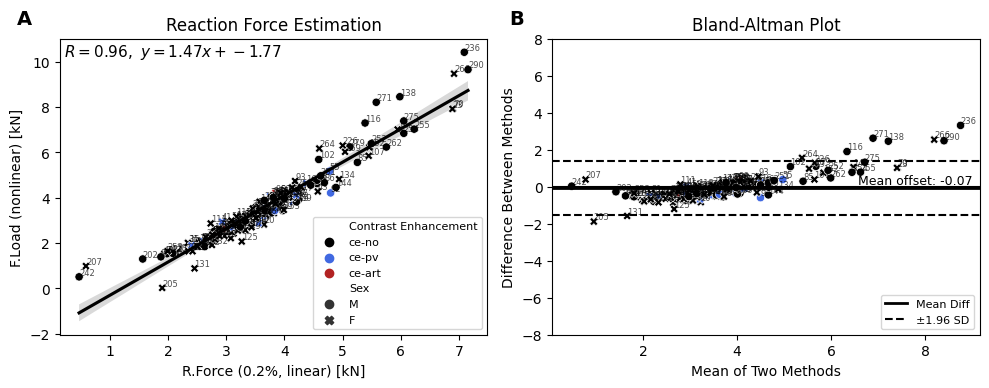

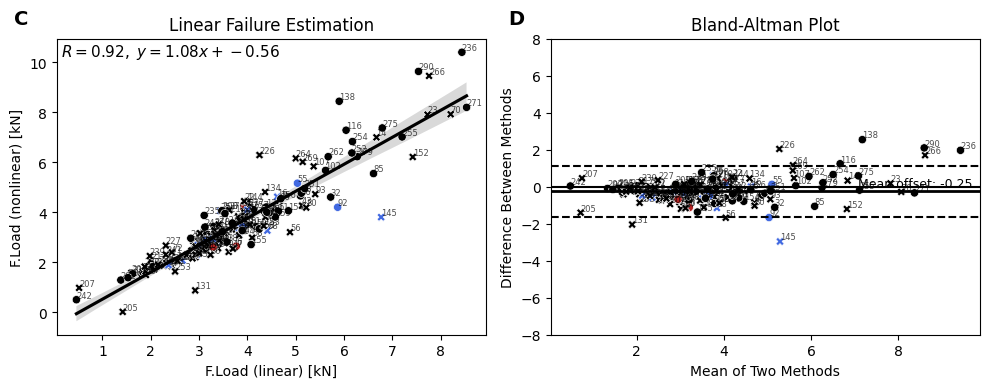

Figure 5. Linear vs nonlinear failure estimation.


In [19]:
# === Figure 5 ===
y_lim = [-8, 8]
tick = 2
col_x = "R.Force (0.2%, linear) [kN]"
col_y = "F.Load (nonlinear) [kN]"
title = "Reaction Force Estimation"
filename = "../results/figures/verse19fem_figure_5_AB.svg"
fig3, axes3 = corr_BA_plot(df,col_x,col_y,bland_ylim=y_lim,tick=tick,title=title,letters=['A','B'],legend=True,filename=filename)

col_x = "F.Load (linear) [kN]"
col_y = "F.Load (nonlinear) [kN]"
title = "Linear Failure Estimation"
filename = "../results/figures/verse19fem_figure_5_CD.svg"
fig3, axes3 = corr_BA_plot(df,col_x,col_y,bland_ylim=y_lim,tick=tick,title=title,letters=['C','D'],filename=filename)
print('Figure 5. Linear vs nonlinear failure estimation.')

In [20]:
# === Global vertebra mappings ===
Vertebra_Numbers = [f"T{i}" for i in range(1, 13)] + [f"L{i}" for i in range(1, 7)]
vertebra_to_number = {f"T{i}": i + 7 for i in range(1, 13)}
vertebra_to_number.update({f"L{i}": i + 19 for i in range(1, 7)})
number_to_vertebra = {v: k for k, v in vertebra_to_number.items()}

# === Data preparation ===
def reshape_to_long_format(df):
    force_cols = {f'R.Force 0.2% T{i} [kN]': f"T{i}" for i in range(1, 13)}
    force_cols.update({f'R.Force 0.2% L{i} [kN]': f"L{i}" for i in range(1, 7)})

    df_long = df.melt(
        id_vars=['subject_ID', 'verse_ID', 'Sex'],
        value_vars=force_cols.keys(),
        var_name='force_column',
        value_name='vertebral_force_kN'
    )
    df_long['Vertebra'] = df_long['force_column'].map(force_cols)
    df_long['Vertebra_Number'] = df_long['Vertebra'].map(vertebra_to_number)
    df_long = df_long.drop(columns='force_column').dropna(subset=['vertebral_force_kN'])

    return df_long.sort_values(['subject_ID', 'verse_ID', 'Vertebra_Number']).reset_index(drop=True)

# === Relative change between adjacent vertebrae ===
def calculate_adjacent_relative_changes(df_long):
    changes = []
    for (subject, verse), group in df_long.groupby(['subject_ID', 'verse_ID']):
        group = group.sort_values('Vertebra_Number')
        for i in range(1, len(group)):
            prev = group.iloc[i - 1]
            curr = group.iloc[i]
            if curr['Vertebra_Number'] - prev['Vertebra_Number'] == 1:
                changes.append({
                    'subject_ID': subject,
                    'verse_ID': verse,
                    'from_vertebra': prev['Vertebra_Number'],
                    'to_vertebra': curr['Vertebra_Number'],
                    'force_from': prev['vertebral_force_kN'],
                    'force_to': curr['vertebral_force_kN'],
                    'relative_change': (curr['vertebral_force_kN'] / prev['vertebral_force_kN']) - 1,
                    'Sex': curr['Sex']
                })
    return pd.DataFrame(changes)

# === Relative to L1 (within subject) ===
def calculate_relative_to_L1_per_subject(df_long):
    df_reduced = df_long[['subject_ID', 'verse_ID', 'Vertebra_Number', 'vertebral_force_kN']].drop_duplicates()
    l1_mean_force = df_reduced[df_reduced['Vertebra_Number'] == 20]['vertebral_force_kN'].mean()

    l1_forces = df_reduced[df_reduced['Vertebra_Number'] == 20][['subject_ID', 'verse_ID', 'vertebral_force_kN']]
    l1_forces = l1_forces.rename(columns={'vertebral_force_kN': 'L1_force'})

    merged = df_reduced.merge(l1_forces, on=['subject_ID', 'verse_ID'], how='left')
    merged['L1_force'] = merged['L1_force'].fillna(l1_mean_force)
    merged['relative_to_L1_subject'] = merged['vertebral_force_kN'] / merged['L1_force'] - 1

    return merged

# === Relative to L1 (population-level graph traversal) ===
def calculate_population_relative_to_L1(adjacent_df):
    mean_changes = (
        adjacent_df.groupby(['from_vertebra', 'to_vertebra'])['relative_change']
        .mean().reset_index()
    )

    graph = defaultdict(list)
    for _, row in mean_changes.iterrows():
        graph[int(row['from_vertebra'])].append((int(row['to_vertebra']), row['relative_change']))
        graph[int(row['to_vertebra'])].append((int(row['from_vertebra']), -row['relative_change']))

    start = 20  # L1 vertebra
    visited = set([start])
    rel_map = {start: 0.0}

    def dfs(v, acc):
        for neighbor, change in graph[v]:
            if neighbor not in visited:
                visited.add(neighbor)
                rel_map[neighbor] = acc + change
                dfs(neighbor, acc + change)

    dfs(start, 0.0)

    if 8 not in rel_map:
        rel_map[8] = 0.0

    return pd.DataFrame([
        {'Vertebra': number_to_vertebra[num], 'Vertebra_Number': num, 'population_relative_to_L1': change}
        for num, change in rel_map.items() if num in number_to_vertebra
    ]).sort_values('Vertebra_Number').reset_index(drop=True)

# === Run pipeline ===
def run_strength_analysis_pipeline(df, sex_filter=None):
    if sex_filter:
        df = df[df['Sex'] == sex_filter].copy()

    df_long = reshape_to_long_format(df)
    df_adjacent = calculate_adjacent_relative_changes(df_long)
    df_subject_l1 = calculate_relative_to_L1_per_subject(df_long)
    df_population_l1 = calculate_population_relative_to_L1(df_adjacent)

    return df_long, df_adjacent, df_subject_l1, df_population_l1

# === Summarize dataframe for manuscript ===

def summarize_graph_model_to_percent(
    df_all, df_male, df_female, 
    output_csv_path='Relative_to_L1_graph_model_percent.csv',
    round_digits=1, multiply_by=100):
    """
    Merge and format population-relative L1 values from graph model across all, male, and female datasets.
    
    Parameters:
    - df_all, df_male, df_female: DataFrames with Vertebra_Number and population_relative_to_L1 columns
    - output_csv_path: str, filename to save output CSV
    - round_digits: int, number of digits to round
    - multiply_by: int or float, scale values (e.g. 100 for percent)

    Returns:
    - merged and formatted DataFrame
    """
    # Sort
    df_all = df_all.sort_values('Vertebra_Number')
    df_male = df_male.sort_values('Vertebra_Number')
    df_female = df_female.sort_values('Vertebra_Number')

    # Merge and rename
    df_combined = (
        df_all[['Vertebra_Number', 'Vertebra', 'population_relative_to_L1']]
        .rename(columns={'population_relative_to_L1': 'relative_to_L1_all'})
        .merge(
            df_male[['Vertebra_Number', 'population_relative_to_L1']]
            .rename(columns={'population_relative_to_L1': 'relative_to_L1_male'}),
            on='Vertebra_Number',
            how='outer'
        )
        .merge(
            df_female[['Vertebra_Number', 'population_relative_to_L1']]
            .rename(columns={'population_relative_to_L1': 'relative_to_L1_female'}),
            on='Vertebra_Number',
            how='outer'
        )
    )

    # Scale and round
    percent_cols = ['relative_to_L1_all', 'relative_to_L1_male', 'relative_to_L1_female']
    df_combined[percent_cols] = df_combined[percent_cols].multiply(multiply_by).round(round_digits)
    df_combined = df_combined.drop(columns='Vertebra_Number')
    df_combined = df_combined.rename(columns={'relative_to_L1_all':'Overall', 'relative_to_L1_male':'Male', 'relative_to_L1_female':"Female"})
    # Save
    df_combined.to_csv(output_csv_path, index=False)

    return df_combined

# Full dataset, Male, Female
df_long_all, df_adjacent_all, df_subject_relative_all, df_population_relative_all = run_strength_analysis_pipeline(df)
df_long_male, df_adjacent_male, df_subject_relative_male, df_population_relative_male = run_strength_analysis_pipeline(df, sex_filter='M')
df_long_female, df_adjacent_female, df_subject_relative_female, df_population_relative_female = run_strength_analysis_pipeline(df, sex_filter='F')

# Save and display
filename = "../results/tables/verse19fem_table_2.csv"

df_graph_combined = summarize_graph_model_to_percent(
    df_population_relative_all,
    df_population_relative_male,
    df_population_relative_female,
    output_csv_path = "../results/tables/verse19fem_table_2.csv"

)

print("Table 2: Relative vertebral strength compared to L1 across thoracic and lumbar levels.")
display(df_graph_combined)


Table 2: Relative vertebral strength compared to L1 across thoracic and lumbar levels.


,Vertebra,Overall,Male,Female
0,T1,-78.1,-78.7,-75.1
1,T2,-54.9,-57.2,-50.4
2,T3,-51.8,-58.2,-44.9
3,T4,-44.9,-51.1,-38.3
4,T5,-33.8,-39.3,-27.6
5,T6,-24.5,-31.7,-17.2
6,T7,-15.4,-23.3,-7.5
7,T8,-6.9,-13.2,-0.4
8,T9,-2.1,-8.4,4.5
9,T10,-2.1,-10.7,6.0


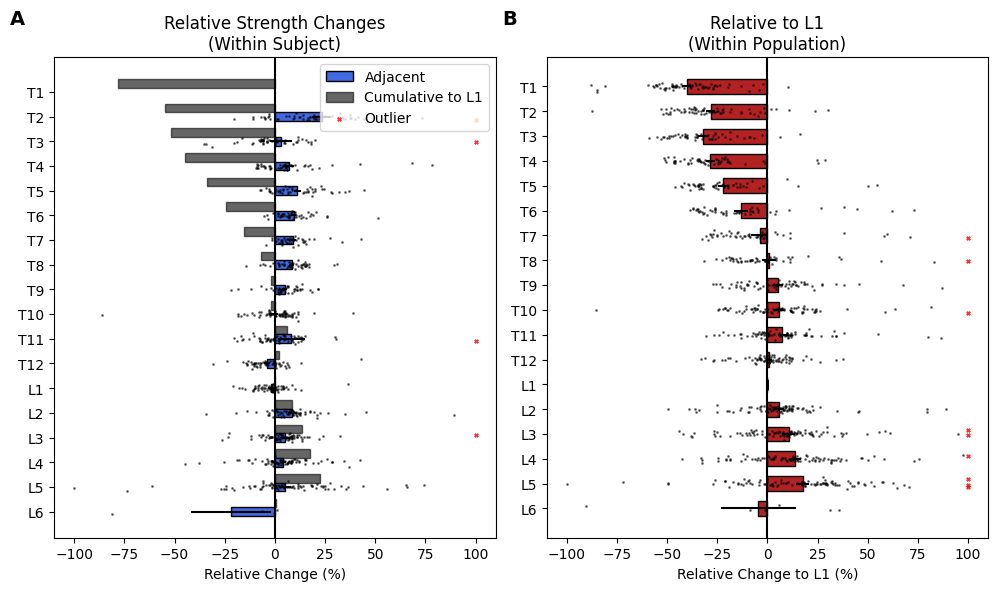

Figure 6. Reference maps of vertebral strength variation.


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_figure_6():
    # === Vertebra label mapping ===
    vertebra_map = {i: f"T{i - 7}" for i in range(8, 20)}
    vertebra_map.update({i: f"L{i - 19}" for i in range(20, 26)})
    vertebra_labels = [f"T{i}" for i in range(1, 13)] + [f"L{i}" for i in range(1, 7)]
    vertebra_order = {label: i for i, label in enumerate(vertebra_labels[::-1])}  # T1 at top

    # === Map labels ===
    df_population_relative_all['label'] = df_population_relative_all['Vertebra_Number'].map(vertebra_map)
    df_adjacent_all['to_label'] = df_adjacent_all['to_vertebra'].map(vertebra_map)
    df_subject_relative_all['label'] = df_subject_relative_all['Vertebra_Number'].map(vertebra_map)

    # === Cumulative data (green/black) ===
    df_population_clean = df_population_relative_all.copy()
    df_population_clean['relative_to_L1_percent'] = df_population_clean['population_relative_to_L1'] * 100

    # === Adjacent data (blue) ===
    summary_rel = (
        df_adjacent_all.groupby(['to_vertebra'])['relative_change']
        .agg(['mean', 'std', 'count'])
        .reset_index()
        .rename(columns={'to_vertebra': 'Vertebra_Number', 'mean': 'mean_change', 'std': 'std_dev'})
    )
    summary_rel['sem'] = summary_rel['std_dev'] / summary_rel['count']**0.5
    summary_rel['adjacent_percent'] = summary_rel['mean_change'] * 100
    summary_rel['adjacent_sem'] = summary_rel['sem'] * 100

    # === Merge for combined plot ===
    df_plot_combined = pd.merge(
        df_population_clean[['Vertebra_Number', 'relative_to_L1_percent']],
        summary_rel[['Vertebra_Number', 'adjacent_percent', 'adjacent_sem']],
        on='Vertebra_Number',
        how='outer'
    )
    df_plot_combined['label'] = df_plot_combined['Vertebra_Number'].map(vertebra_map)
    df_plot_combined = df_plot_combined[df_plot_combined['label'].isin(vertebra_labels)]
    df_plot_combined['label_order'] = df_plot_combined['label'].map(vertebra_order)
    df_plot_combined = df_plot_combined.sort_values('label_order').reset_index(drop=True)
    df_plot_combined['y_pos'] = np.arange(len(df_plot_combined))

    # === Subject-aware L1-relative (orange) ===
    summary_abs = (
        df_subject_relative_all.groupby(['Vertebra_Number', 'label'])['relative_to_L1_subject']
        .agg(['mean', 'std', 'count'])
        .reset_index()
        .rename(columns={'mean': 'mean_change', 'std': 'std_dev'})
    )
    summary_abs['sem'] = summary_abs['std_dev'] / summary_abs['count']**0.5
    summary_abs = summary_abs.sort_values('Vertebra_Number', ascending=True).reset_index(drop=True)
    summary_abs['y_pos'] = np.arange(len(summary_abs))

    # === Plot ===
    fig, axs = plt.subplots(1, 2, figsize=(10, 6), sharey=False)
    clip_min, clip_max = -100, 100

    # --- LEFT: Adjacent (blue) and cumulative (black) ---
    bars_adjacent = axs[0].barh(
        y=df_plot_combined['y_pos'],
        width=df_plot_combined['adjacent_percent'],
        xerr=df_plot_combined['adjacent_sem'],
        color='royalblue',
        edgecolor='black',
        height=0.35,
        label='Adjacent',
        zorder=2
    )
    bars_cumulative = axs[0].barh(
        y=df_plot_combined['y_pos'] + 0.35,
        width=df_plot_combined['relative_to_L1_percent'],
        color='black',
        edgecolor='black',
        height=0.35,
        alpha=0.6,
        label='Cumulative to L1',
        zorder=1
    )

    # Scatter: adjacent values with outliers
    for i, label in enumerate(df_plot_combined['label']):
        values = df_adjacent_all[df_adjacent_all['to_label'] == label]['relative_change'] * 100
        y_center = df_plot_combined.loc[i, 'y_pos']
        y_jitter = np.random.normal(loc=y_center, scale=0.08, size=len(values))

        inliers = (values >= clip_min) & (values <= clip_max)
        axs[0].scatter(values[inliers], y_jitter[inliers], color='black', alpha=0.5, s=1, zorder=3, marker='o')
        axs[0].scatter(
            np.clip(values[~inliers], clip_min, clip_max),
            y_jitter[~inliers],
            color='red', alpha=0.8, s=6, zorder=4, marker='x', label='Outlier' if i == 0 else None
        )

    axs[0].set_xlabel('Relative Change (%)')
    axs[0].set_yticks(df_plot_combined['y_pos'])
    axs[0].set_yticklabels(df_plot_combined['label'])
    axs[0].set_title('Relative Strength Changes\n(Within Subject)')

    # Get all legend handles and labels
    handles, labels = axs[0].get_legend_handles_labels()

    # Sort to put 'Outlier' last
    sorted_handles = [h for l, h in sorted(zip(labels, handles), key=lambda x: (x[0] == 'Outlier', x[0]))]
    sorted_labels = sorted(labels, key=lambda l: (l == 'Outlier', l))

    # Add custom legend
    axs[0].legend(sorted_handles, sorted_labels, loc='upper right')

    # --- RIGHT: Subject-aware relative to L1 ---
    axs[1].barh(
        y=summary_abs['y_pos'],
        width=summary_abs['mean_change'] * 100,
        xerr=summary_abs['sem'] * 100,
        color='firebrick',
        edgecolor='black',
        height=0.6,
        zorder=2
    )

    # Scatter: subject-aware values with outliers
    for i, row in summary_abs.iterrows():
        values = df_subject_relative_all[df_subject_relative_all['Vertebra_Number'] == row['Vertebra_Number']]['relative_to_L1_subject'] * 100
        y_center = row['y_pos']
        y_jitter = np.random.normal(loc=y_center, scale=0.08, size=len(values))

        inliers = (values >= clip_min) & (values <= clip_max)
        axs[1].scatter(values[inliers], y_jitter[inliers], color='black', alpha=0.5, s=1, zorder=3, marker='o')
        axs[1].scatter(
            np.clip(values[~inliers], clip_min, clip_max),
            y_jitter[~inliers],
            color='red', alpha=0.8, s=6, zorder=4, marker='x', label='Outlier' if i == 0 else None
        )

    axs[1].set_xlabel('Relative Change to L1 (%)')
    axs[1].set_yticks(summary_abs['y_pos'])
    axs[1].set_yticklabels(summary_abs['label'])
    axs[1].set_title('Relative to L1\n(Within Population)')

    # --- Styling ---
    for ax in axs:
        ax.axvline(0, color='black', linestyle='-')

    letters = ['A','B']
    for i, ax in enumerate(axs.flatten()):  # or axes.ravel() if you're using subplots
        # Add panel label to top-left in axes coordinates
        ax.text(
            -0.1, 1.1, letters[i],
            transform=ax.transAxes,
            fontsize=14, fontweight='bold',
            va='top', ha='left'
    )


    axs[1].invert_yaxis()
    plt.tight_layout()
    return fig, axs

filename = "../results/figures/verse19fem_figure_6_AB.svg"
fig, axs = plot_figure_6()
fig.savefig(filename, format='svg')

plt.show()
print('Figure 6. Reference maps of vertebral strength variation.')